# Krafthack March 7-8 2022
**Team: Data Liberators**  
- Andris Piebalgs
- Hayden Hohns
- Simon Stavland

# Importing python libraries

In [75]:
import os
import time

from dataclasses import dataclass
from functools import wraps
from typing import Any, Callable

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler
from xgboost.sklearn import XGBRegressor

%matplotlib inline

## Loading dataset

In [46]:
# datasets are stored in the data folder
data_dir = os.path.join("..","data")
dataset_2 = os.path.join(data_dir,"input_dataset-2.parquet")
bolt_pretension_file = os.path.join("bolt_pretension.csv")
prediction_input_file = os.path.join(data_dir,"prediction_input.parquet")
# dataset_1 = os.path.join(data_dir,"input_dataset-1.parquet")  # commented out because it is very large

# validation data
validation_raw = pd.read_parquet(prediction_input_file)
training_data_2 = pd.read_parquet(dataset_2)
# training_data_1 = pd.read_parquet(dataset_1)  # commented out because it is very large

# features are found from the validation set
feature_names = list(validation_raw.columns)

# dataset 2 contains the training data:
x_raw = training_data_2[feature_names]
target_vars = training_data_2.filter(regex="Tensile")


# Preprocessing and feature engineering

In [8]:
# functions for preprocessing pipeline

def log_df_pipe(f: Callable):
    """
    Decorator for logging functions handling dataframes
    Can be applied to functions where a dataframe is the input and output
    Typically functions used with df.pipe(f, *args)
    """
    @wraps(f)
    def wrapper(df, *args, **kwargs):
        start = time.time()
        result = f(df, *args, **kwargs)
        elapsed_time = time.time() - start
        print(f"{f.__name__} took {elapsed_time} seconds")
        print(f"Dataframe shape: {result.shape}")
        print(f"NA in dataframe: {result.isna().sum().sum()}")
        return result

    return wrapper

@log_df_pipe
def copy_df(df:pd.DataFrame):
    return df.copy()

@log_df_pipe
def mode_to_numerical(df: pd.DataFrame):
    df.loc[:, "mode"] = (df["mode"]=="operation").astype(float)
    return df

@log_df_pipe
def drop_na(df: pd.DataFrame):
    return df.dropna(axis=0)


@log_df_pipe
def add_seasonality_features(df: pd.DataFrame) -> pd.DataFrame:
    """Perform pre-processing of data.

    Args:
        df (pd.DataFrame): Dataframe that contains a valid index (datetime).

    Returns:
        pd.DataFrame: Same input dataframe but with extra columns.
    """
    df["month"] = df.index.month
    df["day"] = df.index.day
    # heavy rain: september-november, snow: december-march, melting: april-june, dry: july-august
    # Snow = 1, Melting = 2, Dry = 3, Rain = 4
    seasons = {
        1: 1, 2: 1, 3: 1, 
        4: 2, 5: 2, 6: 2,
        7: 3, 8: 3,
        9: 4, 10: 4, 11: 4,
        12: 1
    }
    df["season"] = df["month"].map(seasons)
    return df

def permissible_stress(
    pressure: pd.Series,
    penstock_diameter: float=2.2,
    penstock_thickness: float = 54e-3,
    efficiency: float = 0.8,
) -> float:
    return pressure * penstock_diameter / (2 * penstock_thickness * efficiency)


@log_df_pipe
def time_since_operation_ended(df: pd.DataFrame):
    df["mode_difference"] = df["mode"] - df["mode"].shift(-1)
    df["time_difference"] = df.index - df.index.shift(-1, freq="S")
    time_since = []
    time = 0.0
    for _, row in df.iterrows():
        if row["mode_difference"] > 0:
            time = 0.0
            time_since.append(time)
        else:
            time += row["time_difference"].seconds
            time_since.append(time)
    df["time_since"] = time_since
    return df

@log_df_pipe
def turbine_deficit_stress(df: pd.DataFrame):
    df["stress_deficit_turbine"] = 3000 - permissible_stress(pressure=df["Turbine_Pressure Drafttube"])
    return df


@log_df_pipe
def select_features(df:pd.DataFrame):
    return df[[
        "Unit_4_Power",
        "Unit_4_Reactive Power",
        "Turbine_Guide Vane Opening",
        "Turbine_Pressure Drafttube",
        "Turbine_Pressure Spiral Casing",
        "Turbine_Rotational Speed",
        "season",
        "month",
        "day",
        "stress_deficit_turbine",
        "time_since",
    ]]


In [9]:
x = (
    x_raw.pipe(copy_df)
    .pipe(drop_na)
    .pipe(mode_to_numerical)
    .pipe(add_seasonality_features)
    .pipe(time_since_operation_ended)
    .pipe(turbine_deficit_stress)
    .pipe(select_features)

)
x_baseline = (
    x_raw.pipe(copy_df)
    .pipe(drop_na)
    .pipe(mode_to_numerical)

)

validation = (
    validation_raw.pipe(copy_df)
    .pipe(drop_na)
    .pipe(mode_to_numerical)
    .pipe(add_seasonality_features)
    .pipe(time_since_operation_ended)
    .pipe(turbine_deficit_stress)
    .pipe(select_features)
)

copy_df took 0.021826982498168945 seconds
Dataframe shape: (1874087, 7)
NA in dataframe: 744522
drop_na took 0.3108551502227783 seconds
Dataframe shape: (1750000, 7)
NA in dataframe: 0
mode_to_numerical took 0.10004925727844238 seconds
Dataframe shape: (1750000, 7)
NA in dataframe: 0
add_seasonality_features took 0.11937594413757324 seconds
Dataframe shape: (1750000, 10)
NA in dataframe: 0
time_since_operation_ended took 83.2208480834961 seconds
Dataframe shape: (1750000, 13)
NA in dataframe: 1
turbine_deficit_stress took 0.012532949447631836 seconds
Dataframe shape: (1750000, 14)
NA in dataframe: 1
select_features took 0.20205903053283691 seconds
Dataframe shape: (1750000, 11)
NA in dataframe: 0
copy_df took 0.02094101905822754 seconds
Dataframe shape: (1874087, 7)
NA in dataframe: 744522
drop_na took 0.2810840606689453 seconds
Dataframe shape: (1750000, 7)
NA in dataframe: 0
mode_to_numerical took 0.09788894653320312 seconds
Dataframe shape: (1750000, 7)
NA in dataframe: 0
copy_df to

### Ensure that nans are removed for target variables too

In [16]:
# Drop nans in target data
def drop_target_nans(targets_df, train_raw_df):
    is_nan_row = train_raw_df.isna().any(axis=1)
    targets_df = targets_df[~is_nan_row]
    return targets_df

In [17]:
targets_df = (
    target_vars.pipe(copy_df)
    .pipe(drop_target_nans, x_raw )
)

copy_df took 0.01587986946105957 seconds
Dataframe shape: (1874087, 6)
NA in dataframe: 744522


In [18]:
assert targets_df.shape[0] == x.shape[0]

# Build ML model

In [22]:
# container for model response
@dataclass
class ModelResponse:
    bolt_name: str
    model: Any
    scaler: Any
    train_mape: float
    test_mape: float
    y_test: Any
    y_pred: Any

In [51]:
def train_bolts_models(train_df, targets_df, model=LinearRegression, model_kwargs = None):
    if model_kwargs is None:
        model_kwargs = {}
        
    res = {}
    
    # Iterate through each target (i.e. each bolt)
    for target_name, target_data in targets_df.iteritems():
        
        print(f"Started training {target_name}")
        
        X_train, X_test = np.split(train_df, [int(.4 *len(train_df))])
        y_train, y_test = np.split(target_data, [int(.4 *len(target_data))])
        
        # Create cross validation pipeline
        scoring = {'mean_absolute_percentage_error': make_scorer(mean_absolute_percentage_error)}
        scaler = StandardScaler()
        m = model(**model_kwargs)
        pipe = Pipeline([('scaler', scaler), ('clf', m)])
        pipe.fit(X_train, y_train)
        
        # Get the mean scores for test and training
        y_pred_test = pipe.predict(X_test)
        train_mape = mean_absolute_percentage_error(y_train, pipe.predict(X_train))
        test_mape = mean_absolute_percentage_error(y_test,y_pred_test)
                
        # save to output dict
        res[target_name] = ModelResponse(bolt_name=target_name, model = m, scaler=scaler, train_mape=train_mape, test_mape=test_mape, y_test=y_test, y_pred=y_pred_test)

        print(f"Finished training {target_name}")
    return res

In [48]:
def plot_results(model_res):
    fig, axs = plt.subplots(6, figsize=(15, 30))
    for i, model_response in enumerate(model_res.values()):
        y_test = model_response.y_test
        y_pred = model_response.y_pred
        axs[i].plot(range(1400,1800), range(1400, 1800))
        axs[i].plot(y_test, y_pred, "o")
        axs[i].set_title(model_response.bolt_name)
        axs[i].set(xlabel="y_test", ylabel="y_pred")

# Baseline model: linear regression

In [52]:
linear_res = train_bolts_models(x_baseline, targets_df)

Started training Bolt_1_Tensile
Finished training Bolt_1_Tensile
Started training Bolt_2_Tensile
Finished training Bolt_2_Tensile
Started training Bolt_3_Tensile
Finished training Bolt_3_Tensile
Started training Bolt_4_Tensile
Finished training Bolt_4_Tensile
Started training Bolt_5_Tensile
Finished training Bolt_5_Tensile
Started training Bolt_6_Tensile
Finished training Bolt_6_Tensile


In [53]:
for response in linear_res.values():
    print(f"train mape: {response.train_mape}, test mape: {response.test_mape}")

train mape: 0.0005555556308020109, test mape: 0.009430944611465732
train mape: 0.0003749974339464169, test mape: 0.0064312071276194085
train mape: 0.00017174596856188757, test mape: 0.0043749975654015175
train mape: 0.00011503614557377184, test mape: 0.0008250728634758007
train mape: 9.282928461177882e-05, test mape: 0.0006537622394948721
train mape: 0.00012057747494532223, test mape: 0.0034180684594015964


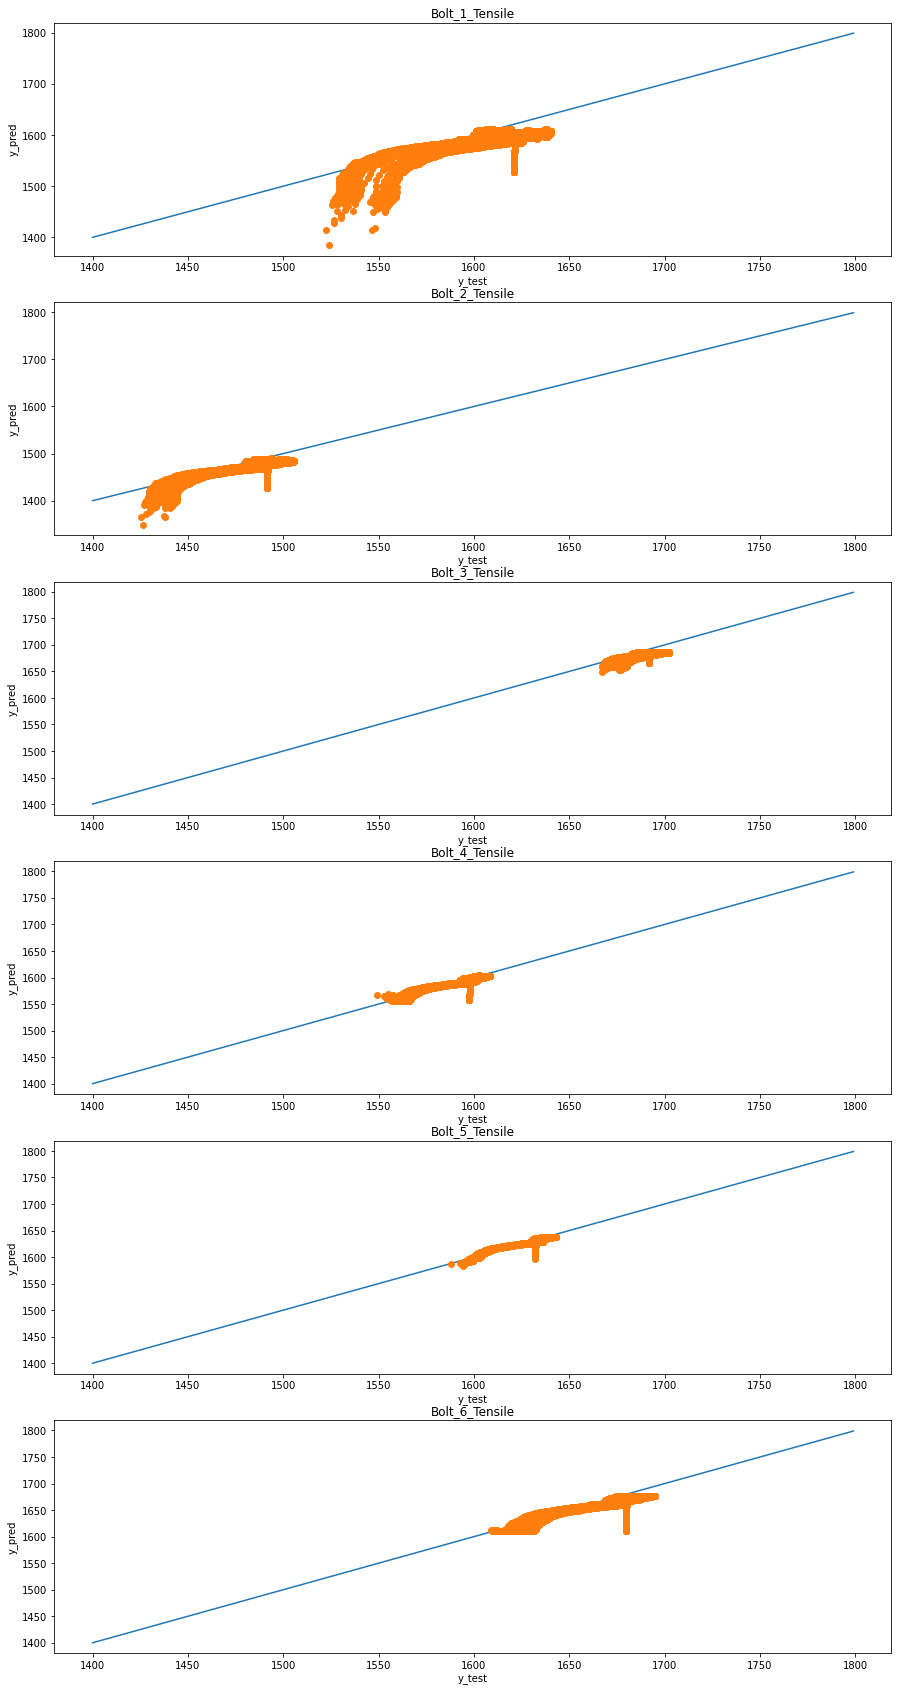

In [54]:
plot_results(linear_res)

# Linear regression with improved features

In [58]:
linear_res_feat_eng = train_bolts_models(x, targets_df)

Started training Bolt_1_Tensile
Finished training Bolt_1_Tensile
Started training Bolt_2_Tensile
Finished training Bolt_2_Tensile
Started training Bolt_3_Tensile
Finished training Bolt_3_Tensile
Started training Bolt_4_Tensile
Finished training Bolt_4_Tensile
Started training Bolt_5_Tensile
Finished training Bolt_5_Tensile
Started training Bolt_6_Tensile
Finished training Bolt_6_Tensile


In [59]:
for response in linear_res_feat_eng.values():
    print(f"train mape: {response.train_mape}, test mape: {response.test_mape}")

train mape: 0.00017236692165561063, test mape: 0.014528225775081584
train mape: 0.00012367445245119865, test mape: 0.009898132625390325
train mape: 9.09990552878528e-05, test mape: 0.005821907728260486
train mape: 9.532133292532728e-05, test mape: 0.0010655886343484038
train mape: 8.99966335869977e-05, test mape: 0.0009160438225345351
train mape: 0.00010907799075600808, test mape: 0.003698645519948864


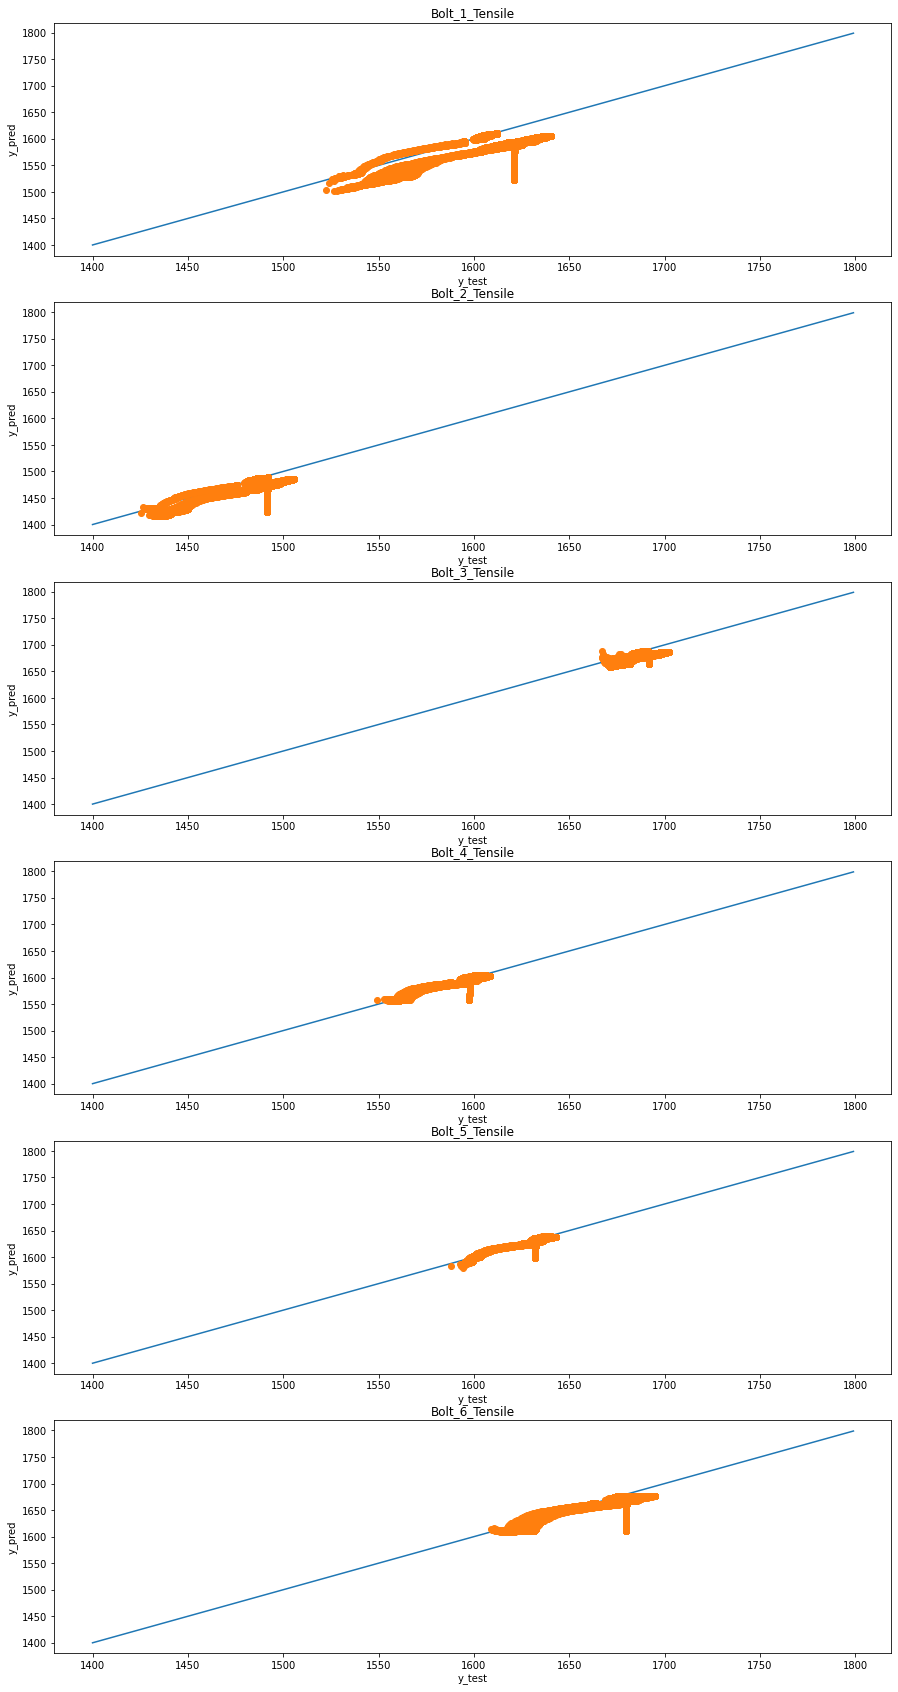

In [60]:
plot_results(linear_res_feat_eng)

# Non linear ML Model: Random Forrest regression

In [ ]:
nonlinear_res = train_bolts_models(x, targets_df, model=RandomForestRegressor, model_kwargs = {"n_estimators":20, "max_depth": 4})

Started training Bolt_1_Tensile
Finished training Bolt_1_Tensile
Started training Bolt_2_Tensile


In [ ]:
for response in nonlinear_res.values():
    print(f"train mape: {response.train_mape}, test mape: {response.test_mape}")

In [ ]:
plot_results(nonlinear_res)

# Non linear ML model: Xgboost

In [ ]:
nonlinear_xgb_res = train_bolts_models(x, targets_df, model=XGBRegressor, model_kwargs = {"n_estimators":80, "max_depth": 3})

In [ ]:
for response in nonlinear_res.values():
    print(f"train mape: {response.train_mape}, test mape: {response.test_mape}")

In [ ]:
plot_results(nonlinear_res)

# Export csv file with predictions

In [61]:
def create_predictions_df(validation_data: pd.DataFrame, model_responses):
    predictions = []
    timestamps = validation_data.index
    for model_response in model_responses.values():
        validation_data_scaled = model_response.scaler.transform(validation_data)
        y_hat = model_response.model.predict(validation_data_scaled)
        y_hat_series = pd.Series(name=model_response.bolt_name, index=timestamps, data=y_hat)
        predictions.append(y_hat_series)
    
    return pd.concat(predictions, axis=1)

csv_export_filename = "bolt_tensile_predictions.csv"
predictions_df = create_predictions_df(validation, nonlinear_xgb_res)
predictions_df.to_csv(csv_export_filename)

# Visually investigate predictions

[Text(0.5, 0, 'Unit 4 power'), Text(0, 0.5, 'Bolt 1 tensile')]

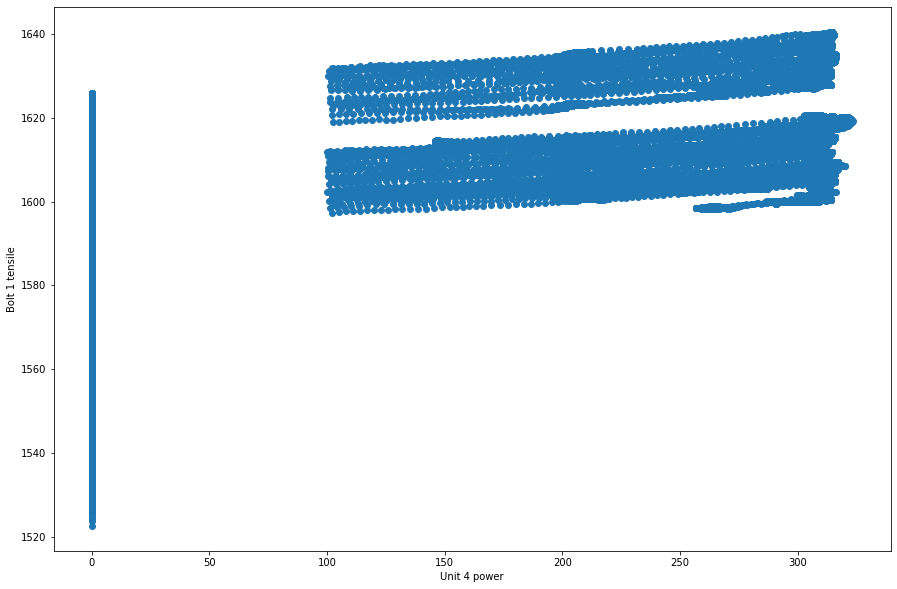

In [62]:
# Compare bolt tension with power in training dataset
fig, axs = plt.subplots(1, figsize=(15, 10))
axs.scatter(x["Unit_4_Power"].values, targets_df["Bolt_1_Tensile"].values)
axs.set(xlabel="Unit 4 power", ylabel="Bolt 1 tensile")


In [ ]:
# Compare predicted bolt tension with power in training dataset

[Text(0.5, 0, 'Unit 4 power'), Text(0, 0.5, 'Bolt 1 tensile')]

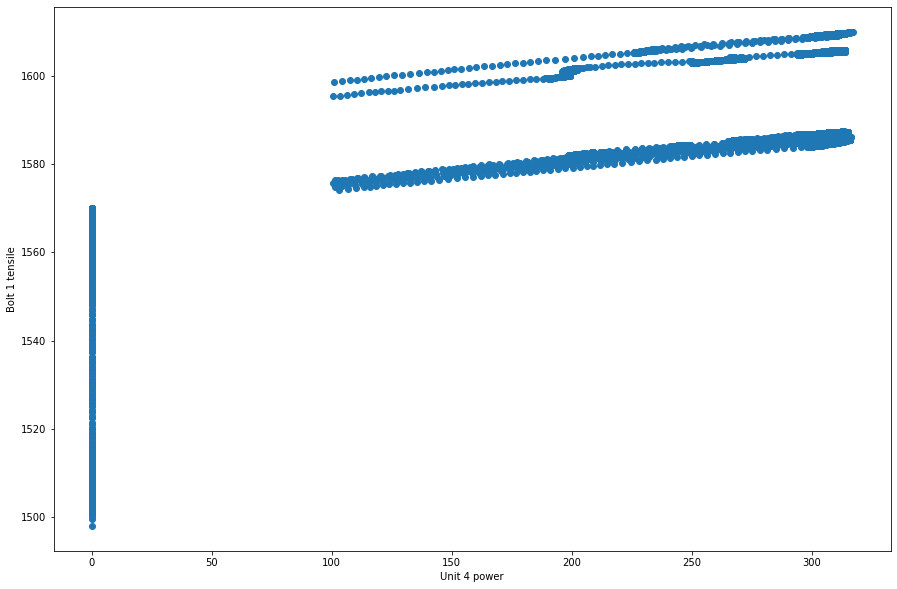

In [63]:
fig, axs = plt.subplots(1, figsize=(15, 10))
axs.scatter(validation["Unit_4_Power"], predictions_df["Bolt_1_Tensile"])
axs.set(xlabel="Unit 4 power", ylabel="Bolt 1 tensile")